In [46]:
!jt -t gruvboxd -f roboto -fs 10
%pylab inline
import IPython
import nodejs
import ipympl
%matplotlib notebook
from astropy.io import fits
import subprocess
import copy
import pprint
import pandas as pd
import warnings
import scipy
from scipy.signal import find_peaks
pp = pprint.PrettyPrinter(width = 41, compact = True)
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Part I: Orienting yourself to the dataset.

Get to know the data: Display the list of available files. Display a header and explore the keywords and their values. This time, all included files will be used. Note 1: when reading in these data using the astropy fits package, you may need to specify the keyword ignore_missing_end=True, or astropy will crash. It may still throw a lot of warnings, but these can be ignored if there are no errors. Note 2: The spectrum will be oriented up-down by default. Please rotate all images as you read them in (e.g. using numpy's rot90() function), so that the spectra run left-right along the detector. This notebook is written assuming that the files have been rotated so that the spectra run left.

In [47]:
#Display the list of available files.
directory = subprocess.os.getcwd() + "\\Ay107Spec"
subprocess.os.listdir(path = directory)
file_array = subprocess.os.listdir(path = directory) #the first and last entries aren't fits files
print(file_array)

['.DS_Store', 'nov05s0002.fits', 'nov05s0003.fits', 'nov05s0004.fits', 'nov05s0005.fits', 'nov05s0006.fits', 'nov05s0007.fits', 'nov05s0016.fits', 'nov05s0017.fits', 'nov05s0038.fits', 'nov05s0039.fits']


In [48]:
#Display a header and explore the keywords and their values
index = 2
path = directory + "\\" + file_array[index]
print("path of file that contains this header:\n", path)
#specify the keyword ignore_missing_end=True, or astropy will crash
hdul = fits.open(name = path, ignore_missing_end=True);
pp.pprint(hdul[0].header)
hdul.close();

path of file that contains this header:
 C:\Users\engin\Documents\GitHub\Ay_Ge_107\Ay107Spec\nov05s0003.fits
SIMPLE  =                    T / Tape is in Fits format                         
BITPIX  =                   32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Number of pixels in axis 1                     
NAXIS2  =                 1024 / Number of pixels in axis 2                     
EXTEND  =                    T                                                  
BSCALE  =              1.00000 / Scaling factor                                 
BZERO   =              0.00000 / Scaling zero-point                             
TELESCOP= 'Keck II           ' / Telescope                                      
OBSERVER= 'Imke, Hammel, de K' / Observer                                       
OBJECT  = '                  ' / Object name                                    


In [49]:
dir(hdul[0])

['_EXCLUDE',
 '_MASK',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_axes',
 '_bitpix',
 '_blank',
 '_bscale',
 '_buffer',
 '_bzero',
 '_calculate_checksum',
 '_calculate_datasum',
 '_char_encode',
 '_checksum',
 '_checksum_valid',
 '_close',
 '_compute_checksum',
 '_compute_hdu_checksum',
 '_convert_pseudo_unsigned',
 '_data_loaded',
 '_data_needs_rescale',
 '_data_offset',
 '_data_replaced',
 '_data_size',
 '_datasum',
 '_datasum_valid',
 '_default_name',
 '_do_not_scale_image_data',
 '_dtype_for_bitpix',
 '_encode_byte',
 '_file',
 '_from_data',
 '_gcount',
 '_get_raw_data',
 '_get_scaled_image_data',
 '_get_timestamp',
 '_has_data',
 '_hdu_registry',
 '_header'

# Q1: Print out a log table in-line:
For each file, the table should include: The file name, the UT time, the target RA and DEC, the target name, the object name, comment entry, the airmass, the filter, and the exposure time. 
Make sure your table has a title on every column, including units when relevant.

In [50]:
row_length = len(file_array) - 1
ut_time = np.array((["UT time"] * row_length))
ra =  np.array((["Right Ascension (decimal degrees)"] * row_length))
dec =  np.array((["Declination (decimal degrees)"] * row_length))
airmass =  np.array((["Airmass (unitless)"] * row_length))
object_name =  np.array((["Object name"] * row_length))
target_name =  np.array((["Target name"] * row_length))
comment_entry =  np.array((["Comment Entries"] * row_length))
filter_name =  np.array((["Filter names"] * row_length))
exposure_time =  np.array((["Exposure times (seconds)"] * row_length))
file_path =  np.array((["File names"] * row_length))
flat =  np.array((["lamp"] * row_length))
coadds = np.array((["Coadds"] * row_length))
itime = np.array((["Integration time"] * row_length))
index_range = 1 + np.array((range(len(file_array) - 2)))
for index in index_range:
    path = directory + "\\" + file_array[index]
    hdul = fits.open(name = path, ignore_missing_end=True);
    ra[index] = hdul[0].header['RA']
    dec[index] = hdul[0].header['DEC']
    ut_time[index] = hdul[0].header['UTC']   
    target_name[index] = hdul[0].header['TARGNAME']
    object_name[index] = hdul[0].header['OBJECT']
    airmass[index] = hdul[0].header['AIRMASS']
    comment_entry[index] = ''.join(hdul[0].header['COMMENT'])
    filter_name[index] = hdul[0].header['FILNAME']
    exposure_time[index] = (hdul[0].header['ITIME'] * 
                               hdul[0].header['COADDS'])
    coadds[index] = hdul[0].header['COADDS']
    itime[index] = hdul[0].header['ITIME']
    file_path[index] = file_array[index]
    flat[index] = hdul[0].header['FLAT']
    hdul.close();
    
table = pd.DataFrame(list(zip(ra, dec, ut_time, target_name, 
            object_name, airmass, comment_entry, filter_name, 
            itime, coadds, exposure_time, file_path, flat)));
table.columns = table.iloc[0,:]
table = table.iloc[1: , :]
table

,Right Ascension (decimal degrees),Declination (decimal degrees),UT time,Target name,Object name,Airmass (unitless),Comment Entries,Filter names,Integration time,Coadds,Exposure times (seconds),File names,lamp
1,#### Error ###,#### Error ###,#### Er,#### Error,,#### Error ###,= 'flat lamp of,NIRSPEC-6,0.25,1,0.25,nov05s0002,0
2,#### Error ###,#### Error ###,#### Er,#### Error,,#### Error ###,= 'flat field,NIRSPEC-6,0.25,1,0.25,nov05s0003,1
3,#### Error ###,#### Error ###,#### Er,#### Error,,#### Error ###,= 'NeArXeKr,NIRSPEC-6,0.25,10,2.5,nov05s0004,0
4,#### Error ###,#### Error ###,#### Er,#### Error,,#### Error ###,= 'NeArXeKr,NIRSPEC-6,0.25,10,2.5,nov05s0005,0
5,#### Error ###,#### Error ###,#### Er,#### Error,,#### Error ###,= 'flat lamp of,NIRSPEC-6,0.25,1,0.25,nov05s0006,0
6,#### Error ###,#### Error ###,#### Er,#### Error,,#### Error ###,= 'flat field,NIRSPEC-6,0.25,1,0.25,nov05s0007,1
7,73.40295,25.36443,10:47:0,HD31033,HD31033,1.07232,"= 'Obs #1, Exp",NIRSPEC-6,1.0,10,10.0,nov05s0016,0
8,73.40114,25.36826,10:47:4,HD31033,HD31033,1.07136,"= 'Obs #1, Exp",NIRSPEC-6,1.0,10,10.0,nov05s0017,0
9,73.30626,21.71514,11:39:2,Io 11:00,Io,1.01129,"= 'Obs #1, Exp",NIRSPEC-6,30.0,1,30.0,nov05s0038,0


# Part II: Flat Field and Spatial Rectification

C:\Users\engin\Documents\GitHub\Ay_Ge_107\Ay107Spec\nov05s0039.fits


<IPython.core.display.Javascript object>


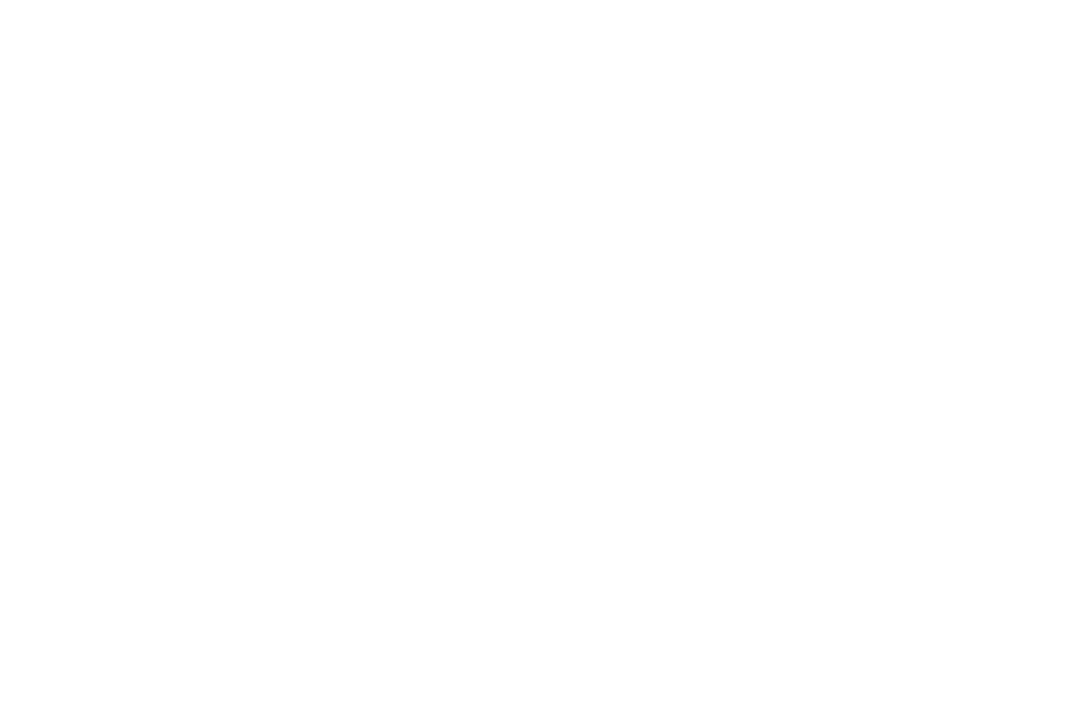

In [51]:
plt.close()
lamp_off_comment = comment_entry[1]
print(directory + "\\" + file_array[-1])
#directory + "\\" + file_array[index]
flat_off_indices = [1, 5]
subtracted_data = []
for index in range(len(flat_off_indices)):
    row = flat_off_indices[index]
    path = directory + "\\" + file_array[row]
    hdul = fits.open(name = path, ignore_missing_end=True);
    lamp_off_data = np.array(hdul[0].data, dtype='float')
    path = directory + "\\" + file_array[row+1]
    hdul = fits.open(name = path, ignore_missing_end=True);
    lamp_on_data = np.array(hdul[0].data, dtype='float')
    subtracted_data.append(np.rot90(lamp_on_data - lamp_off_data))
plt.title("First subtracted flat field")
plt.imshow(subtracted_data[0], origin = "lower")


<IPython.core.display.Javascript object>


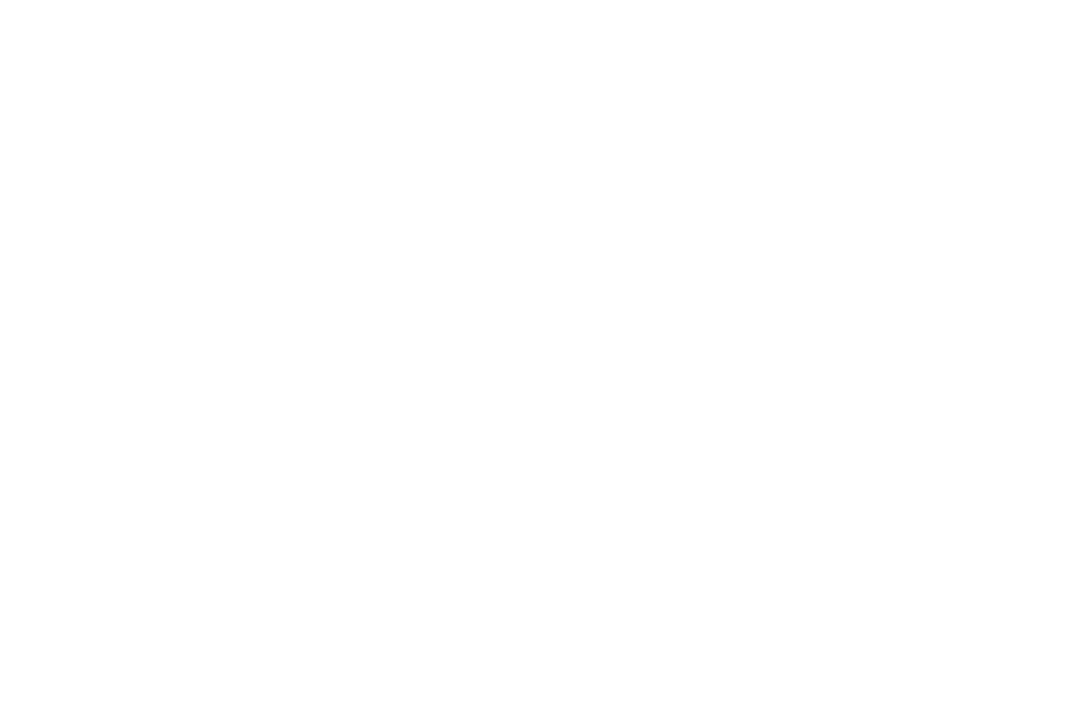

In [52]:
plt.close()
plt.title("Second subtracted flat field")
plt.imshow(subtracted_data[1],  origin = "lower")

Use the two star images to do the spatial rectification. First, subtract the second star image from the first and display the result. Then, determine the y-coordinate of the star at every point along its spectrum. The curve described by that sequence of coordinates is known as the "trace". Draw the trace on top of the images to confirm that it is in the right place.

C:\Users\engin\Documents\GitHub\Ay_Ge_107\Ay107Spec\nov05s0039.fits


<IPython.core.display.Javascript object>


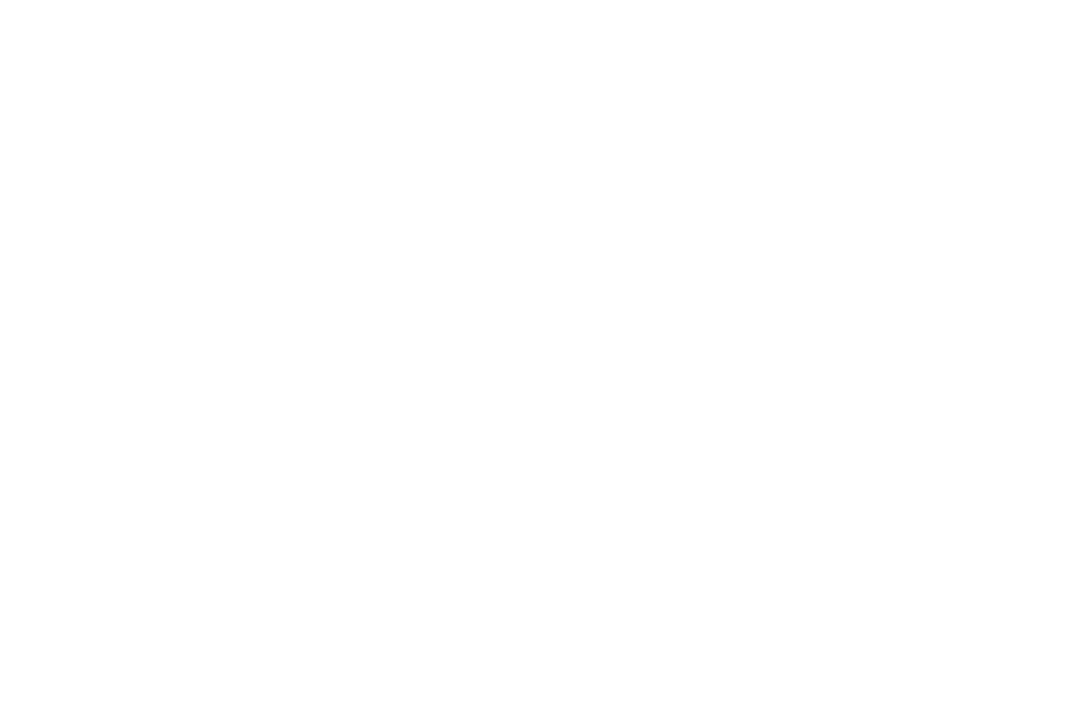

In [53]:
plt.close()
print(directory + "\\" + file_array[-1])
#directory + "\\" + file_array[index]
star_index = 7
path = directory + "\\" + file_array[star_index]
hdul = fits.open(name = path, ignore_missing_end=True);
star_image_1 = np.array(hdul[0].data, dtype='float')
path = directory + "\\" + file_array[star_index+1]
hdul = fits.open(name = path, ignore_missing_end=True);
star_image_2 = np.array(hdul[0].data, dtype='float')
subtracted_star_data = np.rot90(star_image_1 - star_image_2)
plt.title("Subtracted star data")
plt.imshow(subtracted_star_data, origin = "lower")

In [54]:
#Find the y value of the star at every point in the graph
subtracted_star_data = pd.DataFrame(subtracted_star_data)
high_star_y, low_star_y = [], []
for col_number in range(len(subtracted_star_data.columns)):
    column = subtracted_star_data.iloc[:, col_number] 
    high_star_y.append(np.argmax(column))
    low_star_y.append(np.argmin(column))
high_star_y, low_star_y = np.array((high_star_y)), np.array((low_star_y))

# Q2a. Display the stellar pair difference image with the trace for both the positive and negative spectrum drawn on it

<IPython.core.display.Javascript object>


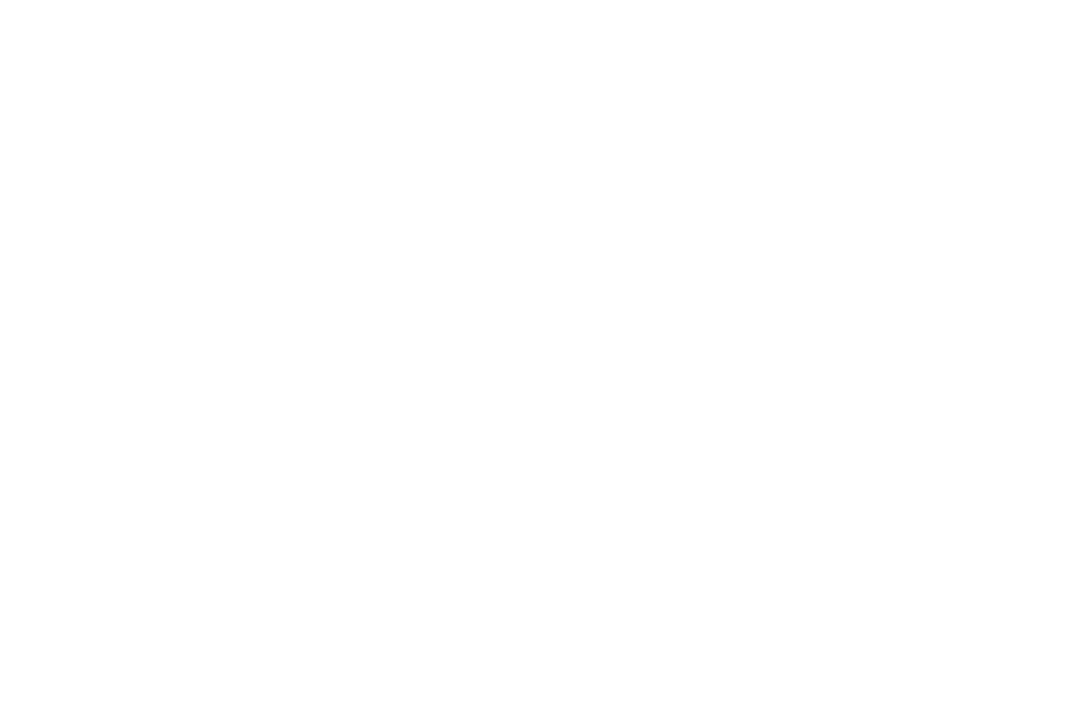

In [55]:
plt.close()
plt.title("Subtracted star data")
plt.imshow(subtracted_star_data, origin = "lower")

These y-coordinates you've calculated for each trace represent the offset of each column that needs to be applied to straighten out the spectrum. Average together the two traces for the positive and negative spectra. Then flatten your star pair image by offsetting each column by the amount of the trace.

# Q2b: Display the rectified star spectrum pair, cropping down to the region of the detector just in the vicinity of the star. The star spectra should lie straight. 

In [56]:
#Select a range around which to crop to include both spectra
diff = high_star_y - low_star_y
diff

array([106, 104, 105, ..., 106, 104, 103], dtype=int64)

<IPython.core.display.Javascript object>


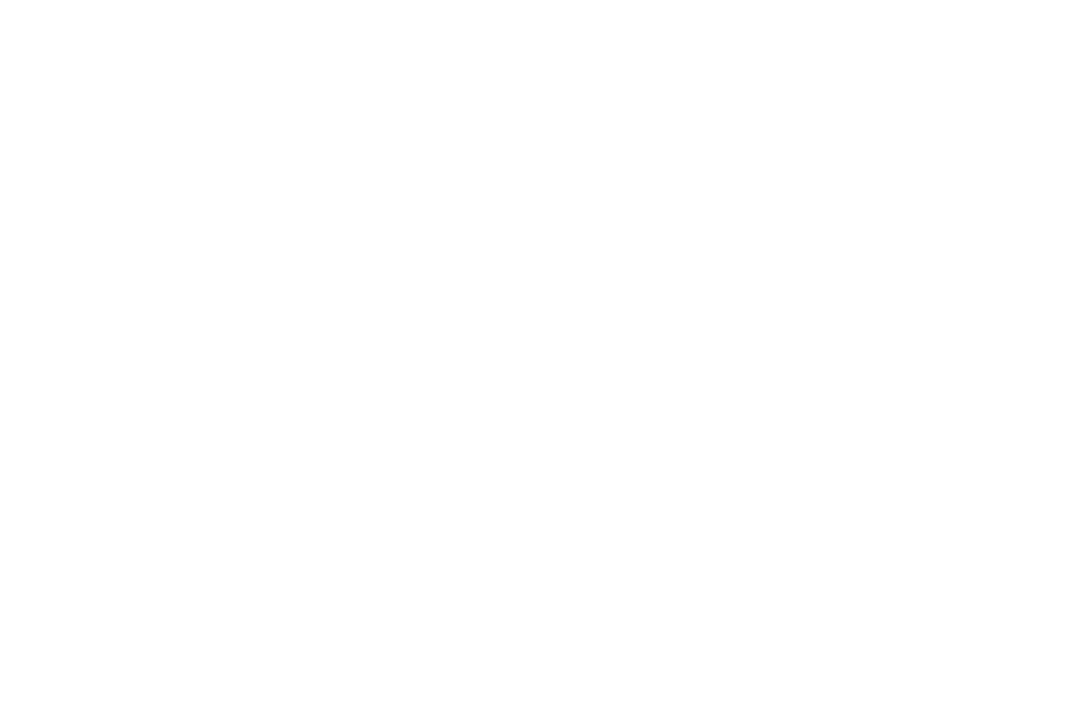

In [57]:
'''
We will shorten each column until it lies just below the minimum signal.
However, each star coordinate then needs to be adjusted to the same height.
Using an array of the y values for each star, we produce a numpy array of
fixed length for each x value in the array.
The two star images will be stored as two different pandas dataframes, 
both of which will only include the illuminated pixels.
'''
high_y_median = int(np.median(high_star_y))
low_y_median = int(np.median(low_star_y)) 
cropped_star_dict = {}
top_margin1, bottom_margin1 = 4, 5
top_margin2, bottom_margin2 = 6, 5

#make arrays with the new borders
top_row_high = high_star_y + top_margin1
bottom_row_high = high_star_y - bottom_margin1
top_row_low = low_star_y + top_margin2
bottom_row_low = low_star_y - bottom_margin2

#use these borders to crop the dataframe
high_star_cropped_dict, low_star_cropped_dict = {}, {}
for col_number in range(len(subtracted_star_data.columns)):
    high_star_cropped_dict[str(col_number)] = pd.Series.to_numpy(
        subtracted_star_data.iloc[max(0, bottom_row_high[col_number]): 
        top_row_high[col_number], col_number])
    low_star_cropped_dict[str(col_number)] = pd.Series.to_numpy(
        subtracted_star_data.iloc[max(0, bottom_row_low[col_number]): 
        top_row_low[col_number], col_number])
    
high_star_cropped = pd.DataFrame.from_dict(high_star_cropped_dict)
low_star_cropped = pd.DataFrame.from_dict(low_star_cropped_dict)
plt.close()
plt.title("Cropped Star Data Positive Image")
plt.imshow(high_star_cropped, origin = "lower")

<IPython.core.display.Javascript object>


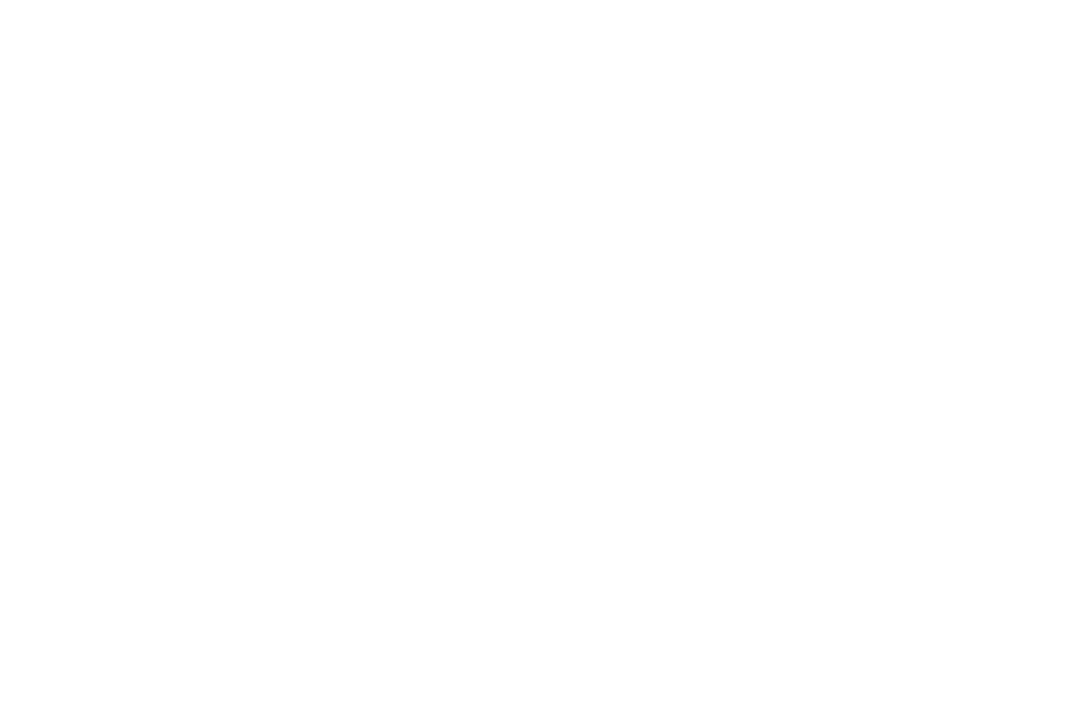

In [58]:
plt.close()
plt.title("Cropped Star Data Negative Image")
plt.imshow(low_star_cropped, origin = "lower")

Now, let's revisit the flat field to create a rectified flat that will be applied to your rectified spectral images. Apply the offsets and crop the flat in exactly the same way you did for the star pair image. Make sure that the new cropped size excludes any of the un-illuminated pixels, which will be visible in the rectified flat if they're not cropped. Finally, divide the rectified, cropped flat field by its median value to normalize it to 1. This is your final flat field that will be applied to the data.

# Q2c. Plot your rectified, cropped, and normalized flat field

<IPython.core.display.Javascript object>


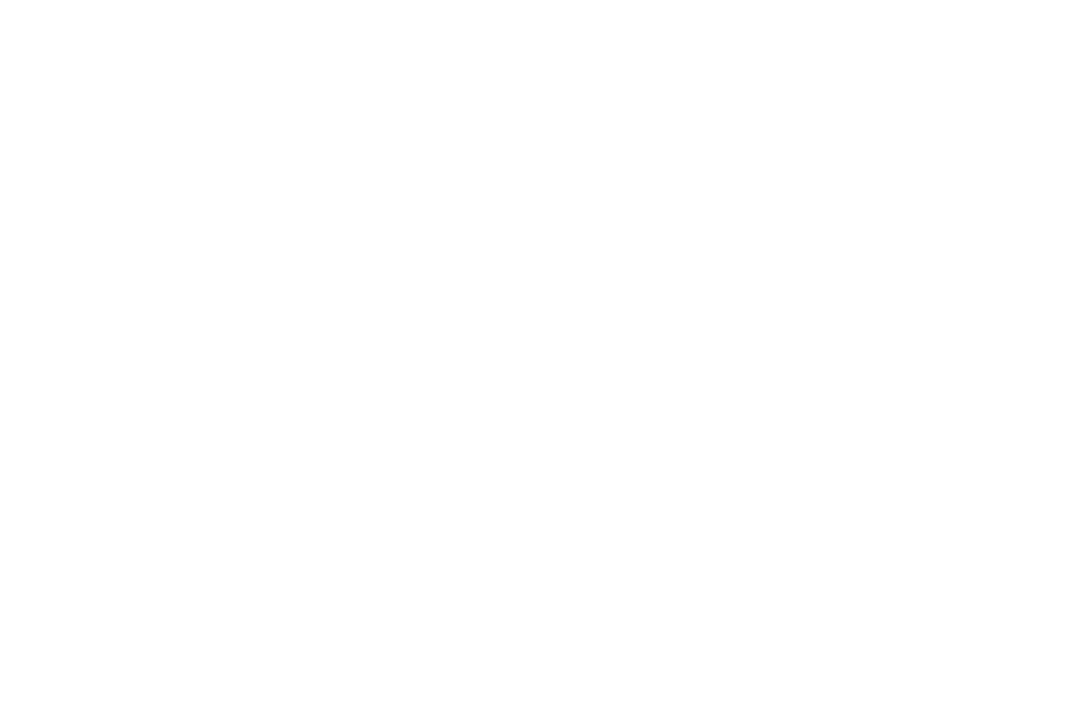

median of each normalized flat: 1.0 and 1.0


<IPython.core.display.Javascript object>


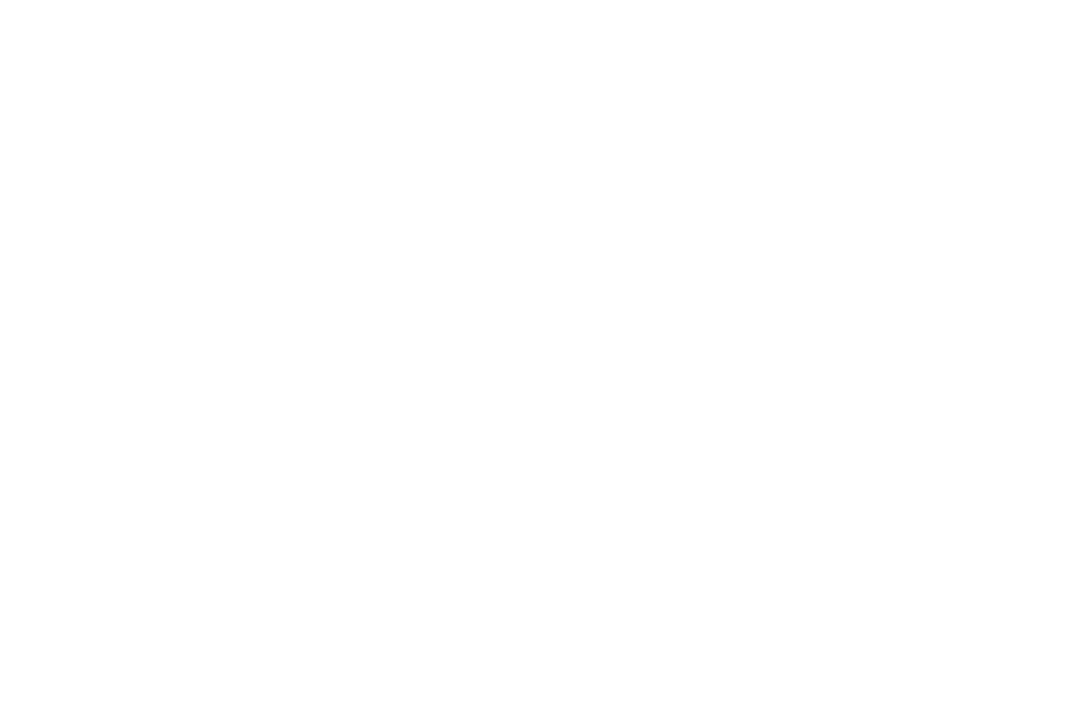

In [59]:
#use these borders to crop the flat dataframe
subtracted_flat = pd.DataFrame(np.mean(subtracted_data, axis = 0))
high_flat_cropped_dict, low_flat_cropped_dict = {}, {}
for col_number in range(len(subtracted_star_data.columns)):
    high_flat_cropped_dict[str(col_number)] = pd.Series.to_numpy(
        subtracted_flat.iloc[max(0, bottom_row_high[col_number]): 
        top_row_high[col_number], col_number])
    low_flat_cropped_dict[str(col_number)] = pd.Series.to_numpy(
        subtracted_flat.iloc[max(0, bottom_row_low[col_number]): 
        top_row_low[col_number], col_number])
    
high_flat_cropped = pd.DataFrame.from_dict(high_star_cropped_dict)
low_flat_cropped = pd.DataFrame.from_dict(low_star_cropped_dict)
plt.close()
plt.title("Cropped Star Data Positive Image")
plt.imshow(high_star_cropped, origin = "lower")

high_flat_median = np.median(high_flat_cropped)
low_flat_median = np.median(low_flat_cropped)
high_flat_normalized = high_flat_cropped / high_flat_median
low_flat_normalized = low_flat_cropped / low_flat_median

print("median of each normalized flat:", np.median(high_flat_normalized), 
      "and", np.median(low_flat_normalized))
plt.close()
plt.title("Rectified, Cropped, and Normalized Flat Data for Positive Data")
plt.imshow(high_flat_normalized, origin = "lower")
#Values seem correct, only the color scheme is different

<IPython.core.display.Javascript object>


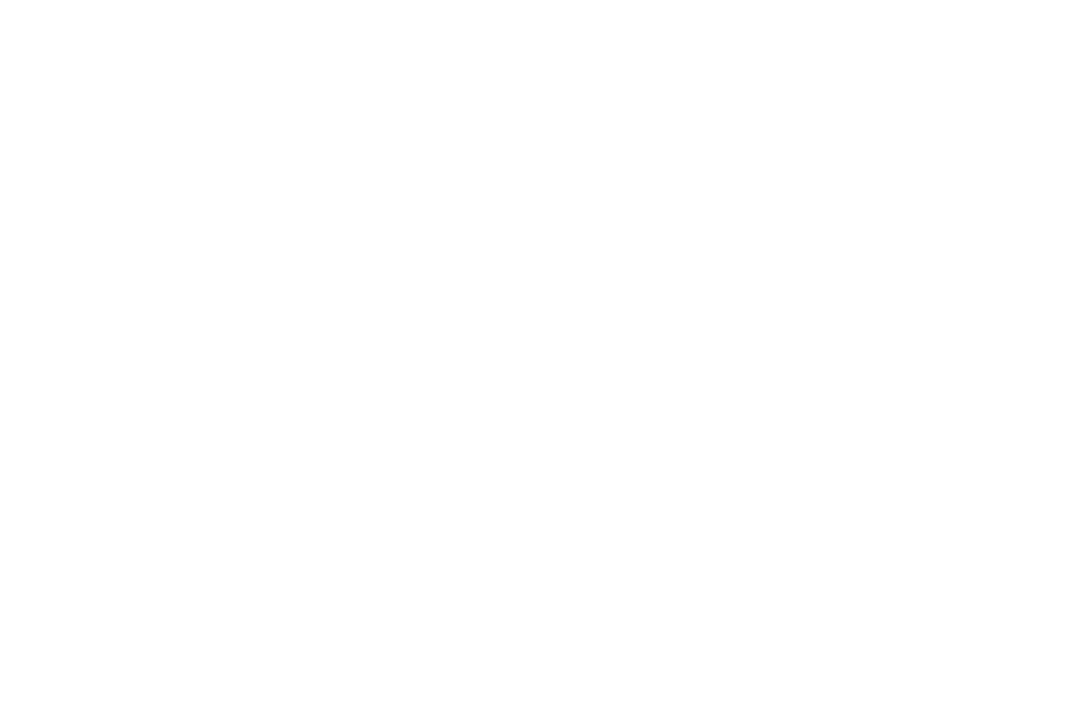

In [60]:
plt.close()
plt.title("Rectified, Cropped, and Normalized Flat Data for Negative Data")
plt.imshow(low_flat_normalized, origin = "lower")
#Values seem correct, only the color scheme is different

## Q2d: Divide your rectified star pair image by the normalized flat field and plot the star pair image before and after the flat correction.

<IPython.core.display.Javascript object>


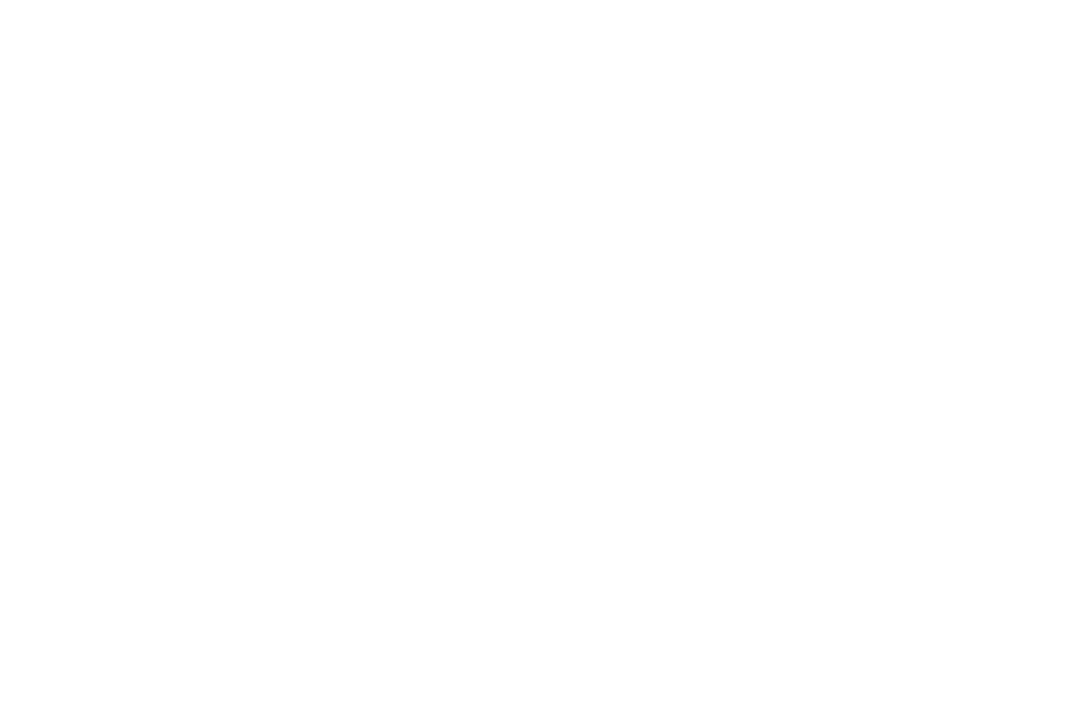

In [61]:
normalized_high_star_data = high_star_cropped / high_flat_normalized
normalized_low_star_data = low_star_cropped / low_flat_normalized
plt.close()
plt.title("Flat Field Corrected Positive Star Image")
plt.imshow(normalized_high_star_data, origin = "lower")

<IPython.core.display.Javascript object>


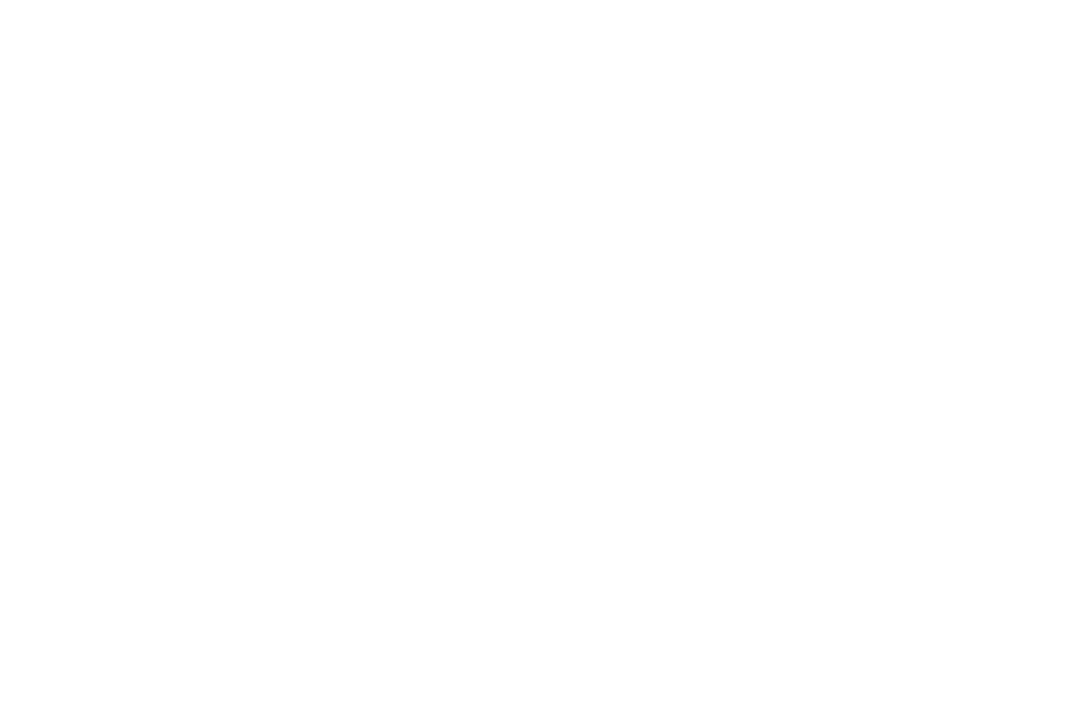

In [62]:
plt.close()
plt.title("Flat Field Corrected Negative Star Image")
plt.imshow(normalized_low_star_data, origin = "lower")

Determine the center y-coordinate of each spectrum. Then, extract the spectrum as follows. For each x-coordinate (wavelength axis), add up pixels within a y-distance "a" of the center of the spectrum. Then, calculate the background for every column by averaging the pixels that are between a distance "b" and a distance "c" of the center of the spectrum. These are the equivalent a/b/c from the imaging aperture photometry, we're just working in one dimension instead of two, and calculating the background separately at every wavelength.

In [63]:
'''
Each star image has its brightest point (and presumably the center) denoted by 
low_star_y (negative image) and high_star_y (positive image)
White corresponds to the borders of the a region, black corresponds to the borders
of the b region, and red corresponds to the orders of the c region.
'''
#here I'll have a corresponding high_a and low_a,high_b and high_b, high_c and low_c
#high corresponds to the positive image and low corresponds to the negative image
high_a, low_a = 5, 6 
#I found a earlier when I cropped the star images
high_b, low_b = 10, 10
#should work based on the maximum and minimum y coordinates of the star arrays
high_c, low_c = 35, 35

# Q2e. Plot the rectified stellar spectrum image with the apertures used for the extraction indicated. i.e. plot as horizontal lines on the rectified star pair image: coord+a, coord-a, coord+b, coord-b, coord+c, and coord-c for each of the two spectra, where "coord" is the y-coordinate at the center of that spectrum

<IPython.core.display.Javascript object>


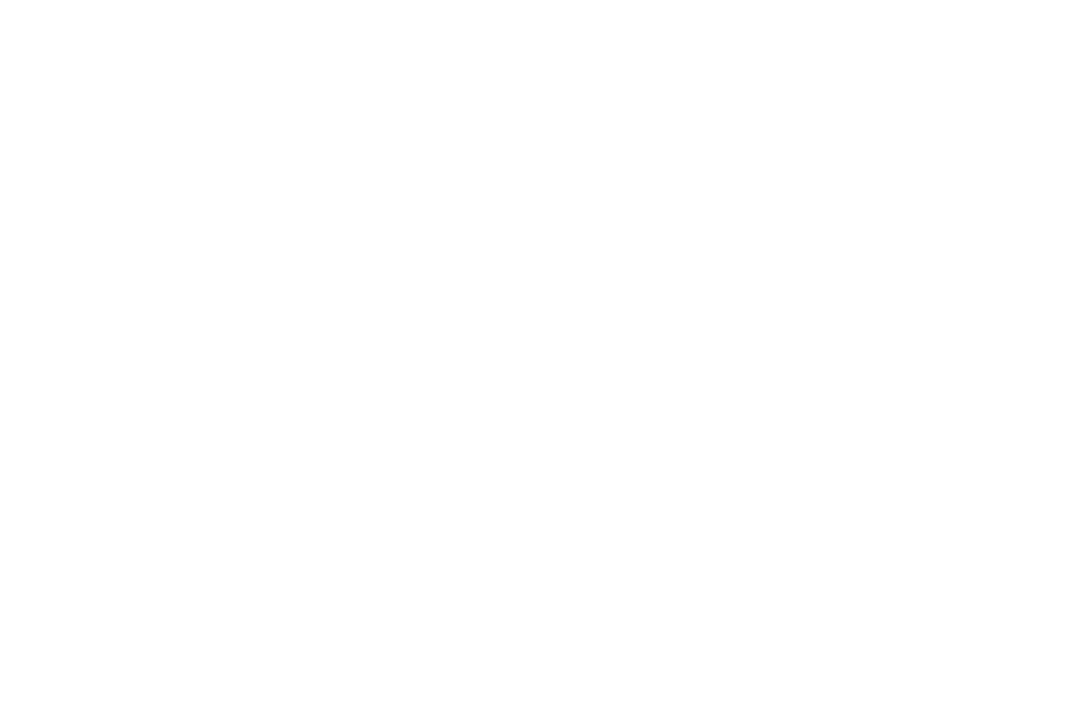

In [64]:
x_array = np.linspace(0, len(high_star_y)-1, len(high_star_y)) #to reuse
region_sizes = np.array((high_a, high_b, high_c, low_a,
                         low_b, low_c)) #to loop through 
array_of_star_coord_arrays = np.array((high_star_y, low_star_y))
border_colors = np.array(("white", "black", "red"))

'''
Loop through each of the borders for the photometric regions, and for each 
border, add and subtract the corresponding region size from each from each 
star image's y coordinate to draw the photometric regions.
'''

plt.close()
plt.imshow(subtracted_star_data, origin = "lower")
for border in range(len(region_sizes)):
    color_index = int(border % len(border_colors)) 
    #the lower and higher borders should be the same color 
    for star_coord_array in array_of_star_coord_arrays:
        plt.scatter(x = x_array, color = border_colors[color_index],
            y = star_coord_array + region_sizes[border])
        plt.scatter(x = x_array, color = border_colors[color_index],
            y = star_coord_array - region_sizes[border])
plt.title("Rectified star data")
plt.show()


<IPython.core.display.Javascript object>


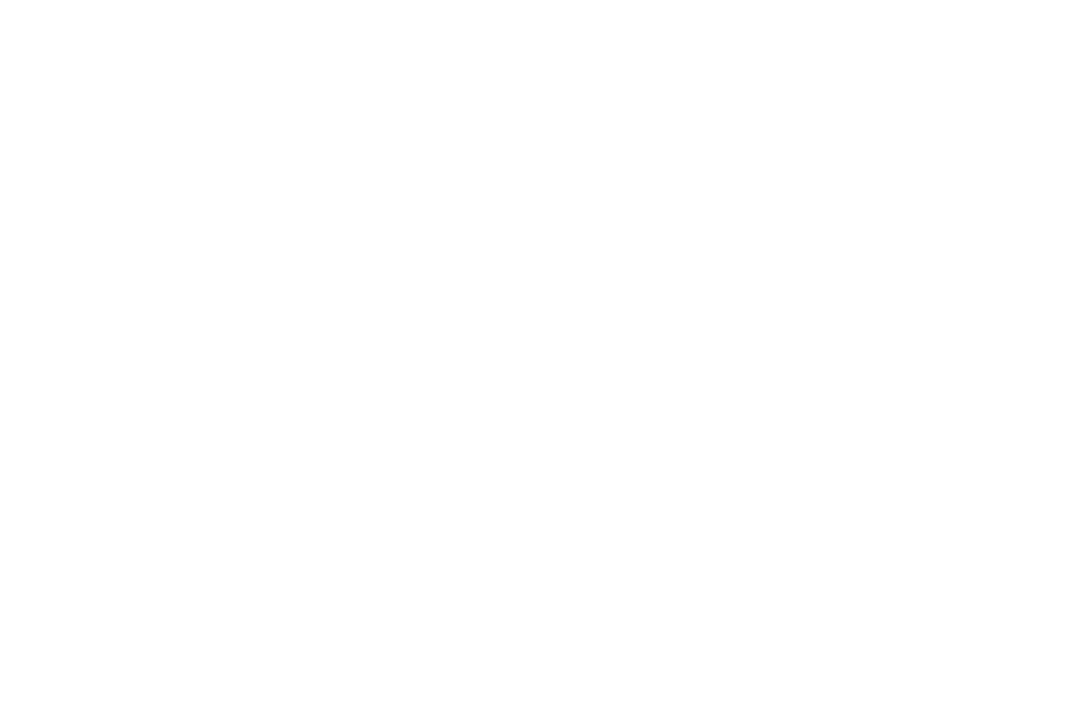

In [65]:
'''
Now we will crop our data to make each photometric region a rectangle 
and each star image a horizontal line, the same way we had done before
with the cropped star images and the cropped star flats.
Now the size of our aperture will stretch from the highest photometric
region to the lowest photometric region.
Since the distance between the regions illuminated by each star varies,
we will convert each image pair separately, then append them. 
'''

#Here we have arrays defining the borders of each photometric region
high_y_plus_c = high_star_y + high_c
high_y_minus_c = high_star_y - high_c
low_y_plus_c = low_star_y + low_c
low_y_minus_c = low_star_y - low_c
'''
This dictionary will contain the data within the rectangular photometric regions
'''
photometric_regions_dict = {}

for col_number in range(len(subtracted_star_data.columns)):
    '''
    Since the distance between the regions illuminated by each star varies,
    we will convert each image pair separately, then append them. 
    '''
    top_column = pd.Series.to_numpy(
        subtracted_star_data.iloc[high_y_minus_c[col_number]: 
      high_y_plus_c[col_number], col_number])
    bottom_column = pd.Series.to_numpy(
        subtracted_star_data.iloc[low_y_minus_c[col_number]: 
      low_y_plus_c[col_number], col_number])
    photometric_regions_dict[str(col_number)] = np.append(
        bottom_column, top_column)
    
union_of_photometric_regions = pd.DataFrame.from_dict(photometric_regions_dict)
plt.close()
plt.title("Photometric regions of star image pair")
plt.imshow(union_of_photometric_regions, origin = "lower")

<IPython.core.display.Javascript object>


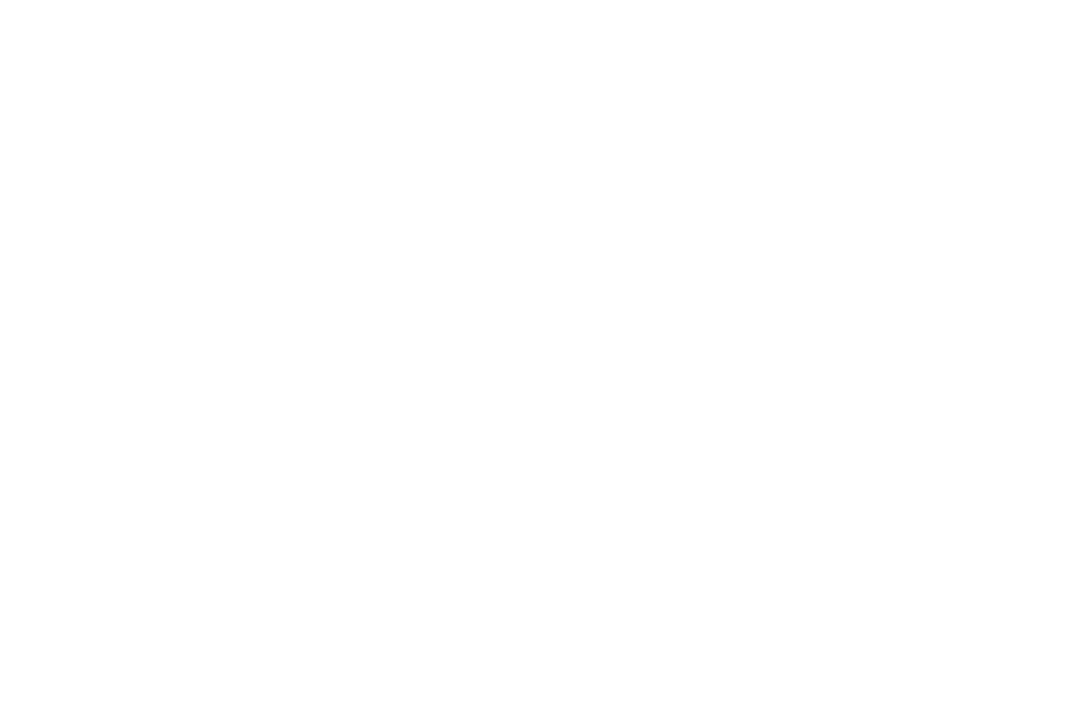

In [66]:
'''
Now we will convert the photometric regions in the uncropped 
image to the cropped image with the same color coding
'''
def convert_y_from_uncropped_to_cropped(uncropped_y, object_y, c):
    cropped_y = uncropped_y - object_y + c
    return cropped_y

plt.close()
plt.imshow(union_of_photometric_regions, origin = "lower")

c_array = np.array((high_c, low_c))
'''
Pair index cycles from the positive star image to the negative star image
'''
for border in range(len(region_sizes)):
    color_index = int(border % len(border_colors)) 
    #the lower and higher borders should be the same color 
    #plot the top border of each photometric region
    for pair_index in range(len(array_of_star_coord_arrays)):
        star_coord_array = array_of_star_coord_arrays[pair_index]
        #plot the top border
        top_border_y_values = convert_y_from_uncropped_to_cropped(
           uncropped_y = star_coord_array + region_sizes[border], 
           object_y  = star_coord_array, c = c_array[pair_index])
        if( not pair_index == len(array_of_star_coord_arrays) - 1 ):
            top_border_y_values += int(2 * low_c)
        plt.scatter(x = x_array, color = border_colors[color_index],
            y = top_border_y_values)
        #plot the bottom border of each photometric region
        bottom_border_y_values = convert_y_from_uncropped_to_cropped(
           uncropped_y = star_coord_array - region_sizes[border], 
            object_y = star_coord_array, c = c_array[pair_index])
        if( not pair_index == len(array_of_star_coord_arrays) - 1 ):
            bottom_border_y_values += int(2 * low_c)
        plt.scatter( x = x_array, color = border_colors[color_index],
            y = bottom_border_y_values )
plt.title("Rectified star data")
plt.show()


Average together the two spectra you extracted, making sure you've subtracted the background and taken the negative of the negative spectrum so that both are positive. Divide by (exposure time x coadds), and label the plot in counts/sec.

C:\Users\engin\Documents\GitHub\Ay_Ge_107\Ay107Spec\nov05s0016.fits  HD31033  HD31033 10 10.0
C:\Users\engin\Documents\GitHub\Ay_Ge_107\Ay107Spec\nov05s0017.fits  HD31033  HD31033 10 10.0


<IPython.core.display.Javascript object>


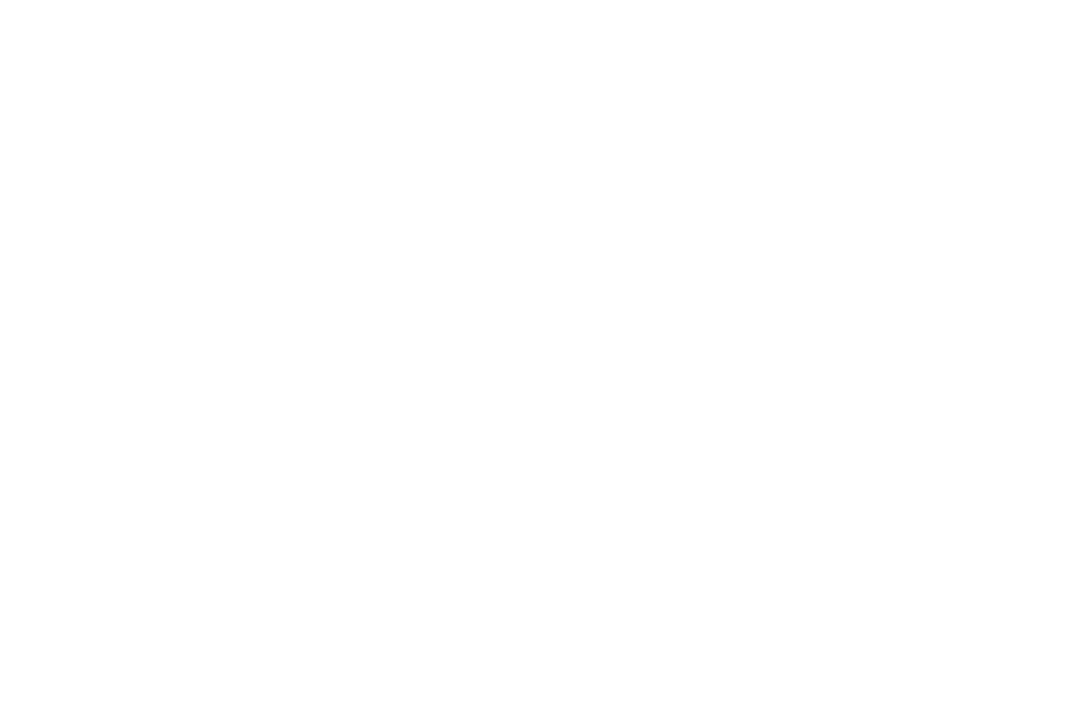

In [67]:
'''
First we will find the y values of the signal from positive image and the 
negative image. For now, we will store each column in an array of y values.
The part of the dataframe we will take to be the signal will be of constant
height determined by the white photometric region; this means y values of the
signal are the set [c-a, c+a] where c is the y value of maximum signal and a 
describes a roughly constant signal domain (as defined previously). 
We can use reuse parts of the for loop from the previous codeblock. 

In conclusion, since we have made the signal a straight horizontal line, we
just need to find an average of each column. For the negative image,
the y value in the cropped version is low_c and for the positive image, it
high_c + 2 * low_c (see the whiteboard images directory for a drawing of the 
columns)
Afterwards, find an average counts/pixel in each column, then subtract the 
background.
'''

y_range_negative_backgroud = np.append( np.arange( 0, low_c - low_b + 1 ), 
                                     np.arange( low_c + low_b, 2 * low_c + 1) )
y_range_positive_background = np.append( np.arange( 2 * low_c, 
                                2 * low_c + high_c - high_b + 1 ), 
                                np.arange(  2 * low_c + high_c, 
                                2 * low_c + high_c + high_b + 1 ) )
positive_background = union_of_photometric_regions.iloc[ 
                        y_range_positive_background, :]
negative_background = union_of_photometric_regions.iloc[
                        y_range_negative_backgroud, :]
avg_positive_background = np.array(( positive_background.mean() ))
avg_negative_background = np.array(( negative_background.mean() ))
#now we have the averaged background counts/pixel for each image

y_positive_signal_max = int( high_c + 2 * low_c )
y_negative_signal_min = int( low_c )
y_range_positive_signal = np.arange( y_positive_signal_max - high_a , 
                                   y_positive_signal_max + high_a + 1 )
y_range_negative_signal = np.arange( y_negative_signal_min - low_a , 
                                   y_negative_signal_min + low_a + 1 )
#crop the data to include just the signal and average each column
positive_star_image = union_of_photometric_regions.iloc[ 
                        y_range_positive_signal, :]
negative_star_image = union_of_photometric_regions.iloc[
                        y_range_negative_signal, :]
avg_negative_spectra = np.array(( negative_star_image.mean() ))
avg_positive_spectra = np.array(( positive_star_image.mean() ))
#now we have the averaged signal in counts/pixel for each column
#now to subtract the sky background
subtr_positive_spectra = avg_positive_spectra - avg_positive_background
subtr_negative_spectra =  avg_negative_spectra - avg_negative_background
averaged_star_spectra = (subtr_positive_spectra - subtr_negative_spectra) / 2
#Print the number of coadds in each image
for index in [7, 8]:
    path = directory + "\\" + file_array[index]
    hdul = fits.open(name = path, ignore_missing_end=True);
    specific_object_name = hdul[0].header['OBJECT']
    coadds = hdul[0].header['COADDS']
    print(path, object_name[index], specific_object_name, coadds, 
          exposure_time[index])
#Adjust for the exposure time (for these images, the number of coadds)
averaged_star_spectra /= coadds
pixel_array = np.arange(len(averaged_star_spectra))

plt.close()
plt.scatter(pixel_array, averaged_star_spectra)


# Q2f: Plot the averaged stellar spectrum in counts/sec vs. pixel

<IPython.core.display.Javascript object>


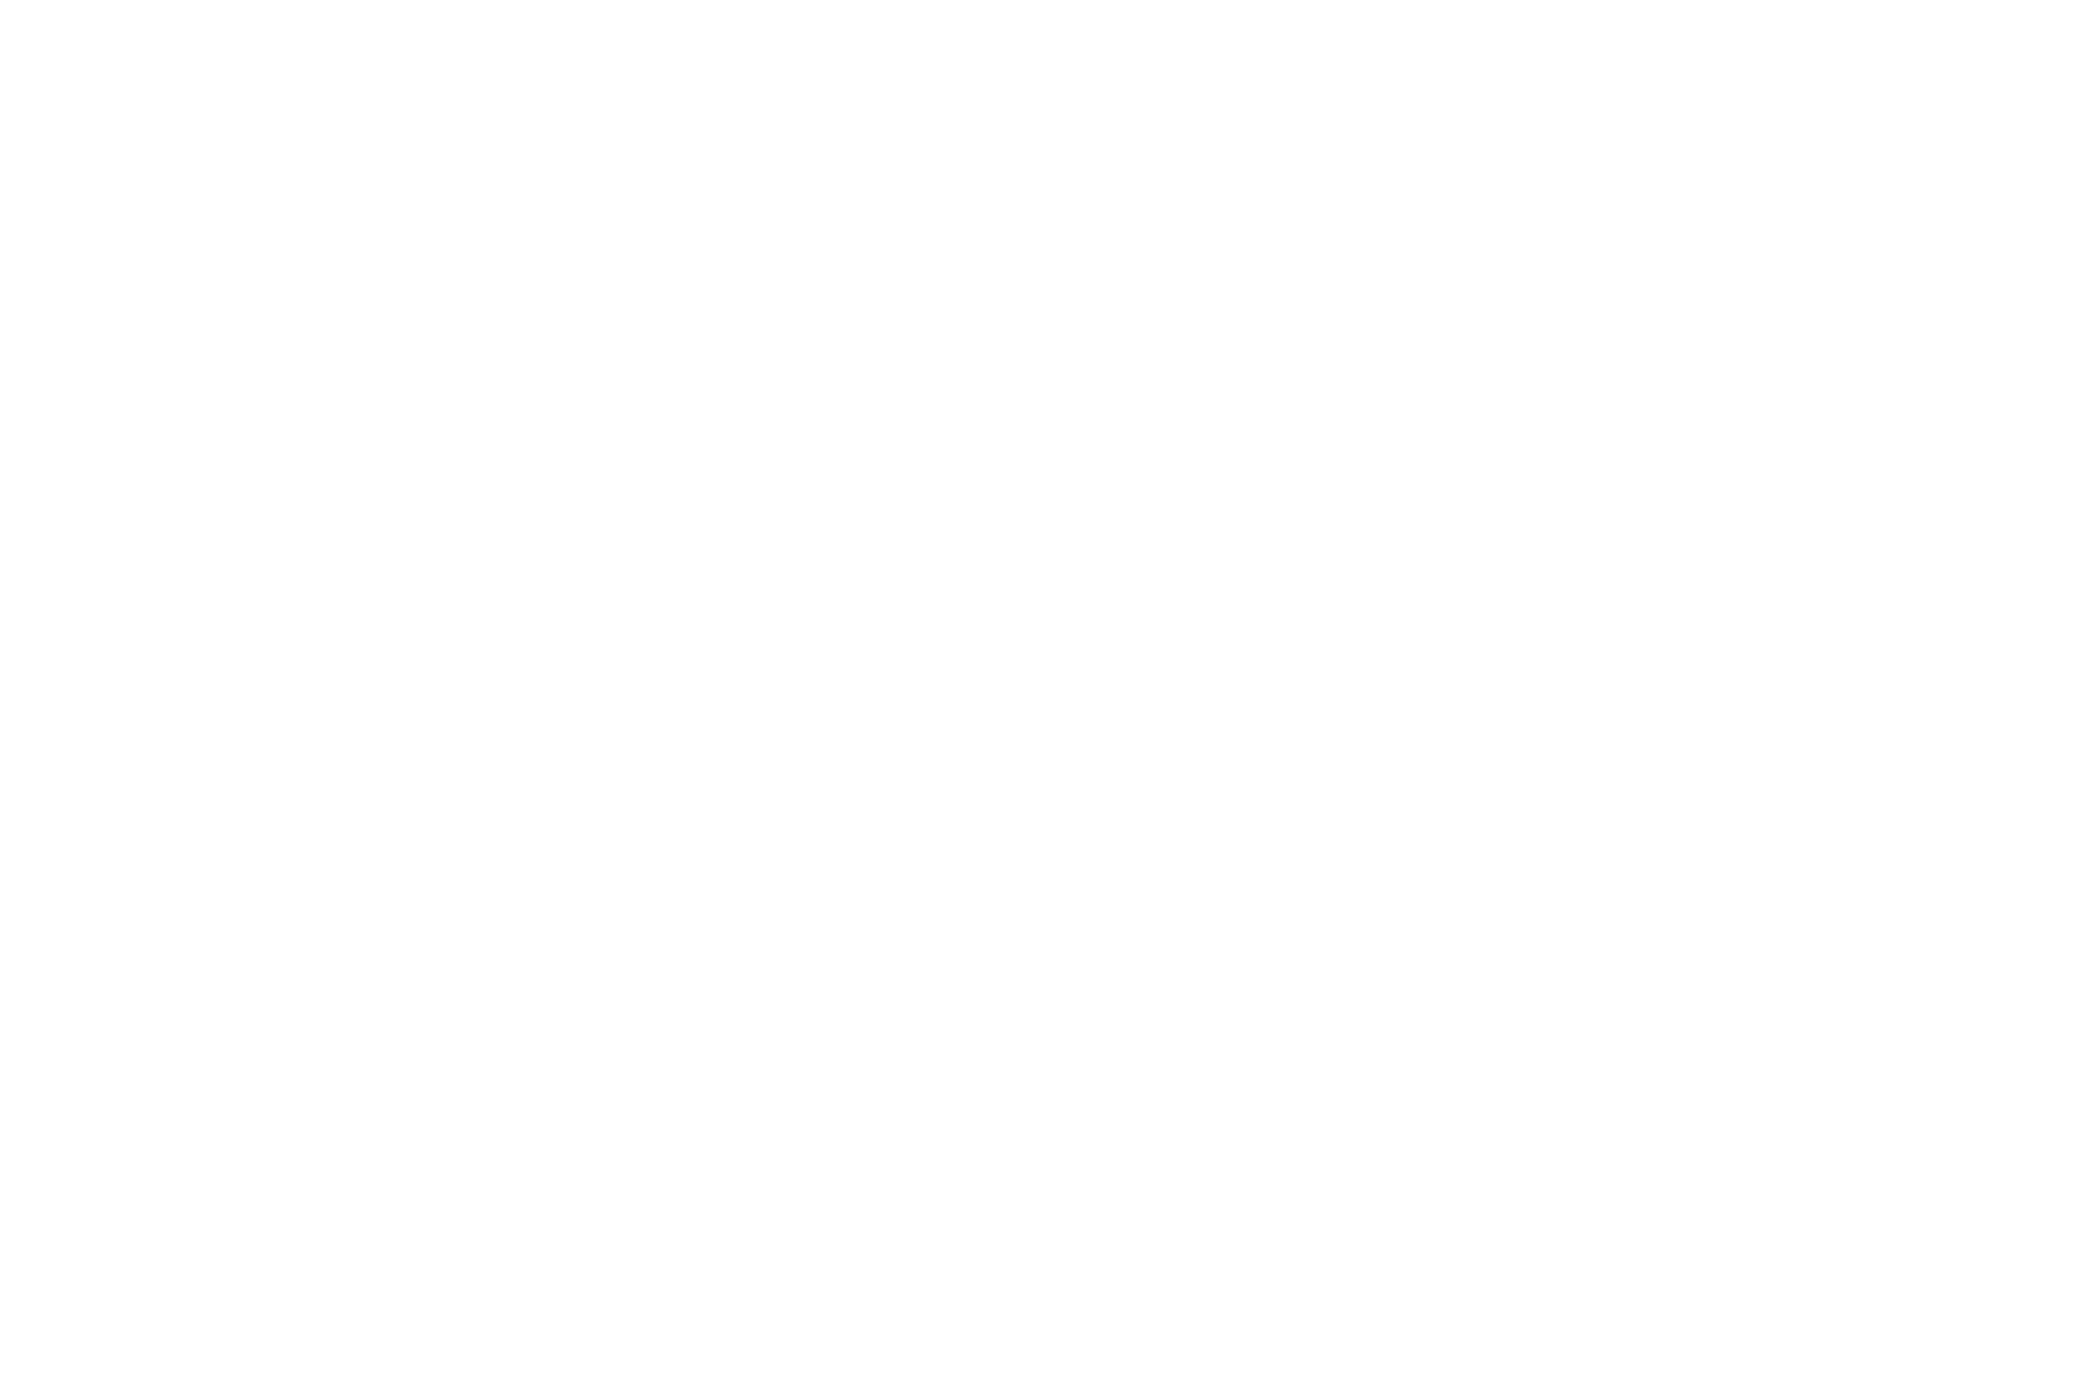

In [68]:
#convolving the data with a uniform function to smoothen it
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size
smoothened_star_spectra = np.convolve(averaged_star_spectra, 
                                      kernel, mode='same')
plt.close()
plt.figure(dpi = 140)
plt.title("Averaged Stellar Spectrum")
plt.ylabel("Counts/Second")
plt.xlabel("Pixel")
point_size = 5
pixel_array = np.arange(len(smoothened_star_spectra))
plt.scatter(pixel_array, smoothened_star_spectra, 
           s = point_size)
plt.grid(which='major', color='black')
plt.grid(which='minor', color='grey', alpha=0.4)
plt.minorticks_on()

# Q3: Repeat the same procedure as above for the Io pair and plot the Io spectrum in counts/sec vs. pixel

In [69]:
'''
We will turn the above code into functions that conduct the analysis. 
'''

def make_file_path(directory, file_name):
    path = str(directory) + "\\" + str(file_name)
    return path

def extract_image_data(file_path):
    hdul = fits.open(name = file_path, ignore_missing_end=True);
    image_data = np.array(hdul[0].data, dtype='float')
    return image_data

'''
subtract_image_pairs(object_image_1, object_image_2, rotate) takes 2 
two-dimensional numpy arrays named object_image_1 and object_image2 as input 
as well as a Boolean named rotate.
object_image_1 and object_image_2 should be numpy arrays of the image
data for a dither pattern (presumably ABBA). 
The function will subtract object_image_2 from object_image_1. If the boolean
named rotate is True, the resulting two-dimensional numpy array will be rotated 90
degrees. The function then returns the resulting two-dimensional numpy array.
'''

def subtract_image_pairs(object_image_1, object_image_2, rotate):
    if(rotate):
        subtracted_image_pair = np.rot90(object_image_1 - object_image_2)
    else:
        subtracted_image_pair = object_image_1 - object_image_2
    return subtracted_image_pair

'''
get_signal_y_coords(subtracted_image_pair) returns a tuple of two numpy arrays.
The first numpy array contains the list of y values of the pixels of maximum
illumination in the subtracted image pair. The second numpy array contains 
the list of the y values of the pixels of minimum illumination in the 
subtracted_image_pair. These numpy arrays of y values are taken to be the 
center of the pixels illuminated by the object in the positive and negative 
images, respectively. 
'''

def get_signal_y_coords(subtracted_image_pair):
    subtracted_image_pair = pd.DataFrame(subtracted_image_pair)
    y_signal_positive, y_signal_negative = [], []
    for col_number in range(len(subtracted_image_pair.columns)):
        column = subtracted_image_pair.iloc[:, col_number] 
        y_signal_positive.append(np.argmax(column))
        y_signal_negative.append(np.argmin(column))
    y_signal_positive = np.array((y_signal_positive))
    y_signal_negative = np.array((y_signal_negative))
    return ( y_signal_positive, y_signal_negative )

In [70]:
'''
get_photometric_regions(subtracted_image_pair, a, b, c) returns the a tuple
named photometric regions. 
'''
def get_photometric_regions(subtracted_image_pair, a, b, c):
    
    return photometric_regions

def get_cropped_image_pair(subtracted_image_pair):
    
    return cropped_image_pair


In [118]:
def smoothen_spectrum(unsmoothed_spectrum, kernel_size):
    kernel_size = int(kernel_size)
    kernel = np.ones(kernel_size) / kernel_size
    smoothened_spectra = np.convolve(unsmoothed_spectrum, 
                                kernel, mode='same')
    return smoothened_spectra
    
'''
deconvolve_column(column, kernel_size) and deconvolve_column(image, 
kernel_size) are functions that will loop through each column in a dataframe
and deconvolve each column with a uniform response. 
'''    
   
def image_median(image, distance):
    new_image = image
    d = distance
    row_num_array = np.array(range(image.shape[0] - d)) + d
    col_num_array = np.array(range(len(image.columns) - d)) + d
    
    for row_num in row_num_array:
        for col_num in col_num_array:
            sample = image.iloc[row_num - d: row_num + d, 
                                col_num - d: col_num + d].to_numpy()
            new_image.iloc[row_num, col_num] = np.median(sample)
    return new_image
    
def deconvolve_column(column, kernel_size):
    kernel_size = int(kernel_size)
    kernel = np.ones(kernel_size) / kernel_size
    deconv_image = scipy.signal.deconvolve(column, kernel)[0]
    return deconv_image

def deconvolve_image(image, kernel_size):
    deconv_dict = {}
    for col_number in range(len(image.columns)):
        column = pd.Series.to_numpy(image.iloc[:,col_number])
        deconv_dict[str(col_number)] = deconvolve_column(column,kernel_size)
    deconv_image = pd.DataFrame.from_dict(deconv_dict)
    return deconv_image
    
def plot_spectrum(spectrum, object_name, dpi, point_size):
    plt.close()
    plt.figure(dpi = dpi)
    plt.title("Averaged " + object_name + " Spectrum")
    plt.ylabel("Counts/Second")
    plt.xlabel("Pixel")
    pixel_array = np.arange(len(smoothened_star_spectra))
    plt.scatter(pixel_array, smoothened_star_spectra, 
               s = point_size)
    plt.grid(which='major', color='black')
    plt.grid(which='minor', color='grey', alpha=0.4)
    plt.minorticks_on()

<IPython.core.display.Javascript object>


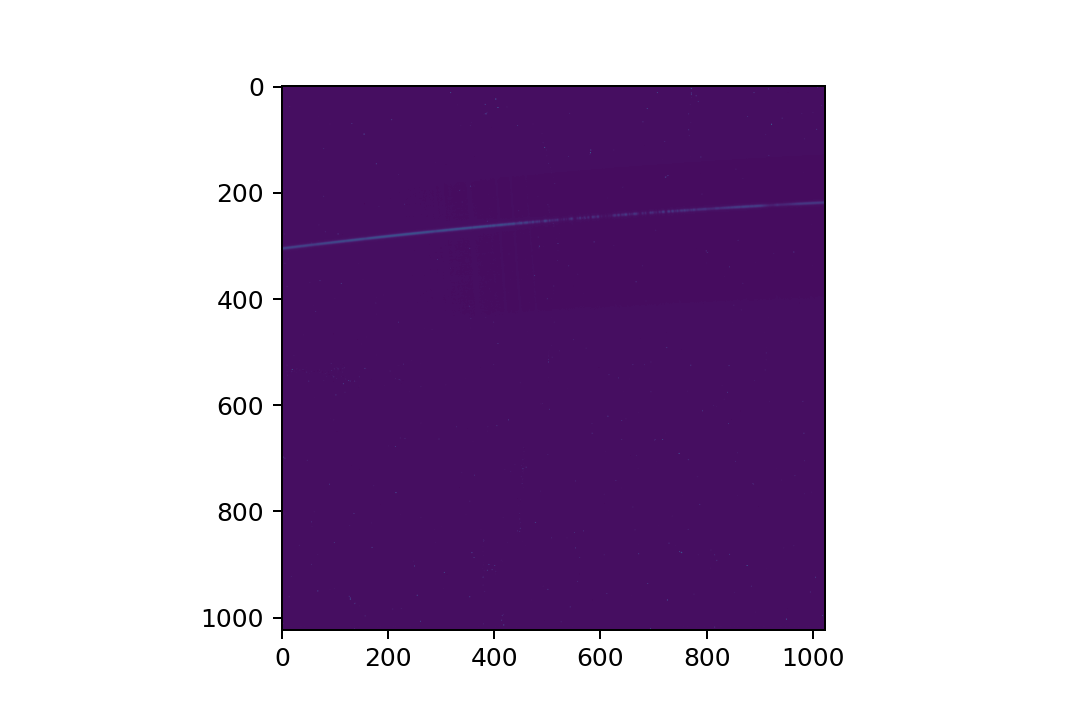

In [119]:
file_path_1 = make_file_path(directory =directory,file_name = file_array[8])
io_image_1 = np.rot90(extract_image_data(file_path_1))
#we can reuse the flat field from earlier
subtracted_flat_image = subtracted_flat 
subtr_io_image = subtract_image_pairs(object_image_1 = io_image_1, 
    object_image_2 = subtracted_flat_image, rotate = False)
plt.close()
plt.imshow(subtr_io_image)


In [120]:
distance = 1
cleaned_io_image = image_median(subtr_io_image, distance)
plt.close()
plt.imshow(cleaned_io_image)
'''
s = 3
deconv_io_image = deconvolve_image(image = subtr_io_image, kernel_size = s)

print(len(y_signal_positive))



smoothened_io_spectrum = smoothen_spectrum(
    unsmoothed_spectrum = averaged_io_spectrum, 
    kernel_size = 20)

plot_spectrum(spectrum = smoothened_io_spectrum, object_name = "Io", 
              dpi = 140, point_size = 5)


'''


AttributeError: 'numpy.ndarray' object has no attribute 'median'

<IPython.core.display.Javascript object>


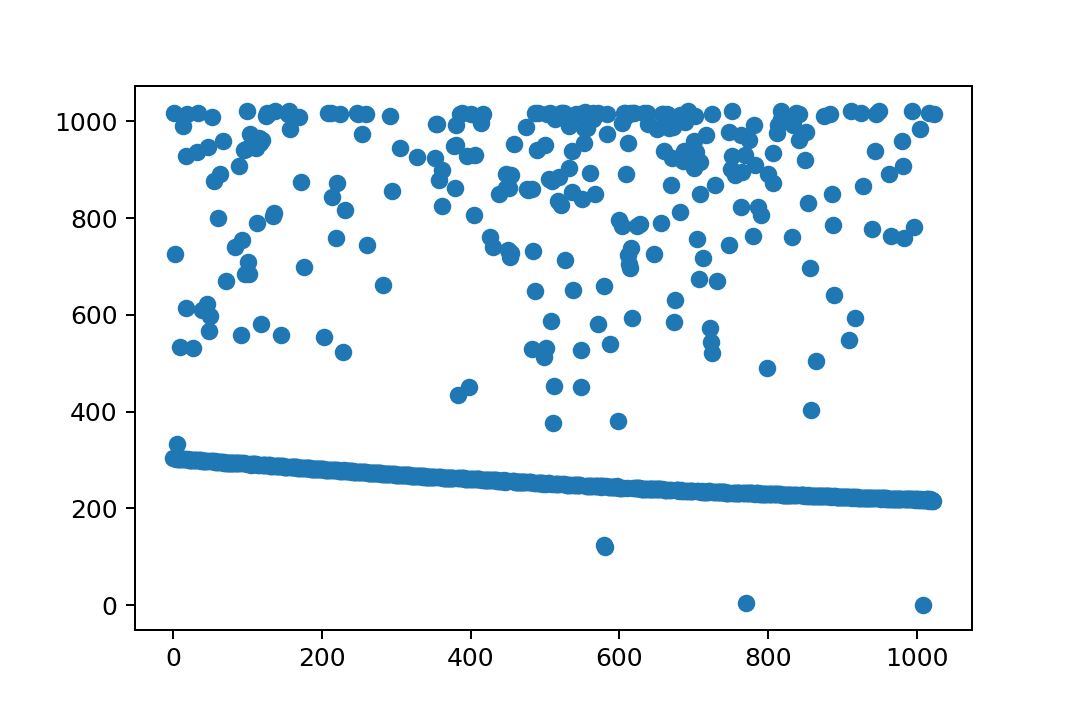

In [113]:
y_signal_positive, y_signal_negative = get_signal_y_coords(deconv_io_image)
plt.close()
plt.scatter(np.arange(len(y_signal_positive)), y_signal_positive)

# Part III: Wavelength Calibration

Rectify, crop and display an arc lamp image. The lines will likely not be perfectly vertical even after the rectification. In a full data reduction pipeline you would correct for this, but for this tutorial we will ignore it.

# Q4a. Display the rectified, flat-fielded, and cropped arc lamp image

Plot a 1-D horizontal cut, i.e. a spectrum for a location around the middle of the slit

Using this spectrum, you will need to correctly identify at least three of the emission lines to determine the function converting pixel coordinate along the spectrum to wavelength. Below is a list of the wavelengths (in microns) of emission lines from the gasses in the arc lamp image. Not all emission lines in the image will have identifications in this list, and not all identifications will have corresponding lines. To attempt to identify them, consider that the spectrum measured should start close to 1.618 microns (left side if you used the np.rot90 function to rotate) and end close to 2.041 microns. And, pixel value should be close to linearly related to wavelength. This is the trickiest part of reducing spectral data!

In [74]:
# Emission lines from the arc lamp gasses, in microns
lines = np.array([1.64414,1.65247,1.65543,1.710811,1.716663,1.723492,1.733023,1.737748,1.741419,1.74497,1.762139,1.763526,
                  1.777507,1.78288,1.800663,1.804072,1.863024,1.86373,1.870102,1.880273,1.98230,
                  1.99503,1.99712,2.00314,2.00751,2.021539,2.03224,2.042955,2.05741,2.06219,2.063185,
                  2.06528,2.07390,2.08168,2.09918])

In [75]:
len(lines)

35

# Q4b. Once you have identified 3 lines, plot the arc spectrum from above again, and indicate the three (or more) lines you're using. Print out the pixel value and wavelength for each.

# Q4c. Make a plot with your line identifications: For each line you identified, plot the pixel value on the x axis and its wavelength on the y axis. If your three points do not lie close to on a line, you've identified something incorrectly. Now, fit a polynomial (degree 1 or 2, but 1 should suffice) to this line. numpy's polyfit function is simple and adequate. That polynomial is your function to convert pixel to wavelength. Add the polynomial to your plot.

# Q4d: Plot the Io spectrum in counts/sec vs. wavelength.

# Part IV: Telluric Correction

We will correct the spectrum for atmospheric absorption analogously to the photometry tutorial, but now using an entire spectrum for the calibration star instead of a single value for a given filter. So, you will create a conversion spectrum (instead of conversion value) that can be applied to your data. The conversion spectrum is a stellar model divided by the stellar spectrum in counts/sec, and thus converts the data from counts/sec into whatever physical units the model was in.

Create a stellar model assuming your star is a 9000 K blackbody. We are not going to worry about absolute scaling of the spectrum, or about getting absolute photometry. So, feel free to rescale the model spectrum by a constant to bring it to a different normalization if you like.

In [76]:
def planck(lam,T):
    # Inputs:
    # lam: an array of wavelengths in microns
    # T: temperature in Kelvins
    # Output:
    # Array of flux densities at each wavelength
    lam = lam*1e-6 # convert from microns to meters
    h = 6.626e-34 # m^2 kg/s
    kb = 1.38e-23 # m^2 kg s^-2 K^-1
    c = 3e8 # m/s
    Blam = (2.0*h*c**2./lam**5.)/(np.exp(h*c/(lam*kb*T))-1) # SI units
    return Blam

# Q5a: Plot the final Io spectrum, in units of Normalized Flux Density vs. Wavelength. Overplot a Planck function that approximates the overall shape of the Io spectrum. Print out the temperature that provided the best fit.

# Q5b. Finally, plot the Io spectrum minus the best-fit Planck spectrum. There is a Sulfur Monoxide gas emission band in the spectrum. Identify where it is. It may help to look at a transmission spectrum of Earth's atmosphere above Mauna Kea, which will help you identify which of the features in Io's spectrum are actually due to Earth.